# Urban sound data classification using deep learning classifiers

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import h5py
import os
import pickle

import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, InputLayer, Dropout, BatchNormalization, Convolution2D, MaxPooling2D, GlobalMaxPool2D
from keras import activations, models, optimizers, losses
from keras.activations import relu
from keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, multilabel_confusion_matrix

## Data pre-processing

### Retrieving and analyzing the metadata

In [8]:
metadata = pd.read_csv('../UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### One-hot encoding

One-hot encoding is the representation of categorical variables as binary vectors. We apply it to the labels, so they are in a format suitable for training neural networks.

In [9]:
def one_hot_encode(label_id):
    onehot = [0]*10   # length of labels array
    onehot[label_id-1]=1
    return onehot

### Reflective padding: our alternative to zero padding 

Reflective padding:

    Reflecting the signal at its boundaries instead of zero padding can help preserve the continuity of the signal, preventing alterations of the signal's characteristics, something that might occur with zero padding.
    It can also help reducing artifacts at the edges of the signal and providing a smooth transition from the original signal to the padded region.
    We believe this approach is effective with sound data, due to its symmetric nature.

In [11]:
def reflective_padding(signal, target_duration, target_rate):
    target_duration = target_duration*target_rate
    current_duration = len(signal)
    
    # Calculate the required padding on each side
    padding_needed = target_duration - current_duration
    left_padding = padding_needed // 2
    right_padding = padding_needed - left_padding
    
    # Reflective padding on both sides
    padded_signal = np.pad(signal, (left_padding, right_padding), 'reflect')
    
    return padded_signal

### Loading and resampling all the data

#### Parameters definition

In [12]:
signal_time = 4    # each signal will have 4 seconds of duration
target_rate = 1000    # resampling frequence

# MFCC parameters
n_mfcc=40
hop_length=round(target_rate*0.0125)
win_length=round(target_rate*0.023)
n_fft=2**14
mfcc_time_size = 4*target_rate//hop_length+1

dataset = []        # [audio, label, fold]
dataset_mfcc = []   # [MFCCs, label, fold]
labels = 10 * [""]   # array that stores the labels by the order specified by the column "classID" in the metadata file

For each sample, we retrieve the audio signal, the MFCC features, the fold it belongs to and the label (one-hot encoded).
We store these informations in two dataframes: one containing the audio signals and one containing the MFCC features.
We also store the labels in an array where its indexes correspond to the "classID" retrieved from the metadata.

In [13]:
for index, row in metadata.iterrows():
    # for fold
    fold = row["fold"]

    # for audio
    signal, rate = librosa.load(f"../UrbanSound8K/audio/fold{fold}/"+row["slice_file_name"], sr=None)
    new_signal = librosa.resample(signal, orig_sr=rate, target_sr=target_rate)
    if len(new_signal) < 4*target_rate:
        new_signal = reflective_padding(new_signal, 4, target_rate)
    audio = new_signal[:4000]
    
    # MFCCs
    sig_mfcc = librosa.feature.mfcc(y=new_signal,sr=target_rate,n_fft=n_fft,hop_length=hop_length,win_length=win_length,n_mfcc=n_mfcc)
    sig_mfcc = sig_mfcc[:,:334]

    # for label
    classID = row["classID"]
    label = one_hot_encode(classID)
    if labels[classID] == "":
        labels[classID] = row["class"]

    dataset.append([audio, label, fold])
    dataset_mfcc.append([sig_mfcc, label, fold])

audio_df = pd.DataFrame(dataset, columns=["audio","label","fold"])
mfcc_df = pd.DataFrame(dataset_mfcc, columns=["mfcc","label","fold"])
print("Dataframe containing the audio signals:")
print(audio_df.tail())
print("\nDataframe containing the MFCC features:")
print(mfcc_df.tail())
print(f"\nOrdered labels: {labels}")

#### Storing the datasets

In [ ]:
with open("../datasets/audio_df.pkl", 'wb') as f:
    pickle.dump(audio_df, f)

with open("../datasets/mfcc_df.pkl", 'wb') as f:
    pickle.dump(mfcc_df, f)
    
with open("../datasets/labels.pkl", 'wb') as f:
    pickle.dump(labels, f)

## Multi-Layer Perceptron

In [2]:
mlp = Sequential()
mlp.add(Dense(200, activation='relu',input_shape=(4000, ))) # input layer  #4000 = sample rate 1000 * 4sec audio
mlp.add(Dropout(0.5))
mlp.add(BatchNormalization())
mlp.add(Dense(200,activation='relu'))
mlp.add(Dropout(0.5))
mlp.add(BatchNormalization())
mlp.add(Dense(200,activation='relu'))
mlp.add(Dropout(0.5))
mlp.add(Dense(10, activation='softmax'))    # output layer

mlp.compile(loss='categorical_crossentropy',
            metrics=['accuracy'],
            optimizer='adam')
# summary
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               800200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 200)              800       
 hNormalization)                                        

In [2]:
def get_mlp():
    mlp = Sequential()
    mlp.add(Dense(200, activation='relu',input_shape=(4000, ))) # input layer  #4000 = sample rate 1000 * 4sec audio
    mlp.add(Dropout(0.5))
    mlp.add(BatchNormalization())
    mlp.add(Dense(200,activation='relu'))
    mlp.add(Dropout(0.5))
    mlp.add(BatchNormalization())
    mlp.add(Dense(200,activation='relu'))
    mlp.add(Dropout(0.5))
    mlp.add(Dense(10, activation='softmax'))    # output layer

    mlp.compile(loss='categorical_crossentropy',
            metrics=['accuracy'],
            optimizer='adam')
    
    return mlp

## CNN

In [10]:
nclass = 10
inp = Input(shape=(40, 334, 1))        # MFCCs
norm_inp = BatchNormalization()(inp)
audio = Convolution2D(32, kernel_size=(3, 3), activation=activations.relu)(norm_inp)
audio = MaxPooling2D(pool_size=(2, 2))(audio)
audio = Dropout(rate=0.1)(audio)
audio = Convolution2D(64, kernel_size=(3, 3), activation=activations.relu)(audio)
audio = GlobalMaxPool2D()(audio)
audio = Dropout(rate=0.1)(audio)

dense_1 = BatchNormalization()(Dense(256, activation=activations.relu)(audio))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

cnn = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

cnn.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 334, 1)]      0         
                                                                 
 batch_normalization_2 (Batc  (None, 40, 334, 1)       4         
 hNormalization)                                                 
                                                                 
 conv2d (Conv2D)             (None, 38, 332, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 166, 32)      0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 19, 166, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 164, 64)       18496 

In [3]:
def get_cnn():    
    nclass = 10
    inp = Input(shape=(40, 334, 1))        # MFCCs
    norm_inp = BatchNormalization()(inp)
    audio = Convolution2D(32, kernel_size=(3, 3), activation=activations.relu)(norm_inp)
    audio = MaxPooling2D(pool_size=(2, 2))(audio)
    audio = Dropout(rate=0.1)(audio)
    audio = Convolution2D(64, kernel_size=(3, 3), activation=activations.relu)(audio)
    audio = GlobalMaxPool2D()(audio)
    audio = Dropout(rate=0.1)(audio)

    dense_1 = BatchNormalization()(Dense(256, activation=activations.relu)(audio))
    dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    cnn = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam()

    cnn.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return cnn

## main run

In [4]:
with open("../datasets/audio_df.pkl", 'rb') as f:
    audio_df = pickle.load(f)
    
with open("../datasets/mfcc_df.pkl", 'rb') as f:
    mfcc_df = pickle.load(f)
    
with open("../datasets/labels.pkl", 'rb') as f:
    labels = pickle.load(f)

In [5]:
mlp_accuracies = []
cnn_accuracies = []
mlp_conf_matrices = []
cnn_conf_matrices = []
for i in range(10):
    # getting training and test sets containing the audio signals
    train_df = audio_df.drop(audio_df[audio_df['fold'] == i+1].index)
    test_df = audio_df.drop(audio_df[audio_df['fold'] != i+1].index)

    X_train = np.array(train_df['audio'].tolist())
    X_test = np.array(test_df['audio'].tolist())
    y_train = np.array(train_df['label'].tolist())
    y_test = np.array(test_df['label'].tolist())
    
    # reloading the MLP
    mlp = get_mlp()
    
    # training the MLP
    n_epochs_mlp = 100
    n_batch_size_mlp = 32
    mlp.fit(X_train, y_train, batch_size=n_batch_size_mlp, epochs=n_epochs_mlp, validation_data=(X_test, y_test))
    y_pred = mlp.predict(X_test,n_batch_size_mlp)
    
    # performance metrics for MLP
    accuracy = mlp.evaluate(X_test,y_test,verbose=0)[1]
    mlp_accuracies.append(accuracy)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    mlp_conf_matrix = confusion_matrix(y_test, y_pred)
    mlp_conf_matrices.append(mlp_conf_matrix)
    
    print(f"\nMLP - fold {i+1} done\n")
    
    # getting training and test sets containing the MFCCs
    train_df = mfcc_df.drop(mfcc_df[mfcc_df['fold'] == i+1].index)
    test_df = mfcc_df.drop(mfcc_df[mfcc_df['fold'] != i+1].index)
    
    X_train = np.array(train_df['mfcc'].tolist())
    X_test = np.array(test_df['mfcc'].tolist())
    y_train = np.array(train_df['label'].tolist())
    y_test = np.array(test_df['label'].tolist())
    
    # reloading the CNN
    cnn = get_cnn()
    
    # training the CNN
    n_epochs_cnn = 10
    n_batch_size_cnn = 32
    cnn.fit(X_train,y_train,epochs=n_epochs_cnn,batch_size=n_batch_size_cnn)
    y_pred = cnn.predict(X_test,n_batch_size_cnn)
    
    # performance metrics for CNN
    accuracy = cnn.evaluate(X_test,y_test,verbose=0)[1]
    cnn_accuracies.append(accuracy)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    cnn_conf_matrix = confusion_matrix(y_test, y_pred)
    cnn_conf_matrices.append(cnn_conf_matrix)
    
    print(f"\nCNN - fold {i+1} done\n")

Epoch 1/100
246/246 [==============================] - 2s 6ms/step - loss: 2.5452 - accuracy: 0.1416 - val_loss: 2.2696 - val_accuracy: 0.1489
Epoch 2/100
246/246 [==============================] - 1s 5ms/step - loss: 2.2914 - accuracy: 0.1729 - val_loss: 2.2490 - val_accuracy: 0.1649
Epoch 3/100
246/246 [==============================] - 1s 5ms/step - loss: 2.1962 - accuracy: 0.1841 - val_loss: 2.2285 - val_accuracy: 0.1649
Epoch 4/100
246/246 [==============================] - 1s 4ms/step - loss: 2.1551 - accuracy: 0.1934 - val_loss: 2.2119 - val_accuracy: 0.1546
Epoch 5/100
246/246 [==============================] - 1s 5ms/step - loss: 2.1058 - accuracy: 0.2143 - val_loss: 2.2172 - val_accuracy: 0.1638
Epoch 6/100
246/246 [==============================] - 1s 4ms/step - loss: 2.0648 - accuracy: 0.2322 - val_loss: 2.2061 - val_accuracy: 0.1856
Epoch 7/100
246/246 [==============================] - 1s 5ms/step - loss: 2.0129 - accuracy: 0.2653 - val_loss: 2.2098 - val_accuracy: 0.1707

In [7]:
mlp_avg_accuracy = np.mean(mlp_accuracies)
mlp_std_dev_accuracy = np.std(mlp_accuracies)
mlp_avg_conf_matrix = np.mean(mlp_conf_matrices,axis=0)

cnn_avg_accuracy = np.mean(cnn_accuracies)
cnn_std_dev_accuracy = np.std(cnn_accuracies)
cnn_avg_conf_matrix = np.mean(cnn_conf_matrices,axis=0)

print(f'''MLP
Average accuracy: {mlp_avg_accuracy}
Accuracy's standard deviation: {mlp_std_dev_accuracy}

CNN
Average accuracy: {cnn_avg_accuracy}
Accuracy's standard deviation: {cnn_std_dev_accuracy}''')

MLP
Average accuracy: 0.17689255774021148
Accuracy's standard deviation: 0.02186023844372127

CNN
Average accuracy: 0.4413173794746399
Accuracy's standard deviation: 0.050849187797625144


### Visualizing accuracy per fold

Multi-Layer Perceptron

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(mlp_accuracies, labels=[1,2,3,4,5,6,7,8,9,10], vert=True, patch_artist=True)
plt.title('Box Plot of Accuracy Across Folds - MLP')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.show()

Convlutional Neural Network

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(mlp_accuracies, labels=[1,2,3,4,5,6,7,8,9,10], vert=True, patch_artist=True)
plt.title('Box Plot of Accuracy Across Folds - CNN')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.show()

### Visualizing confusion matrices

Multi-Layer Perceptron

Text(0, 0.5, 'True Label')

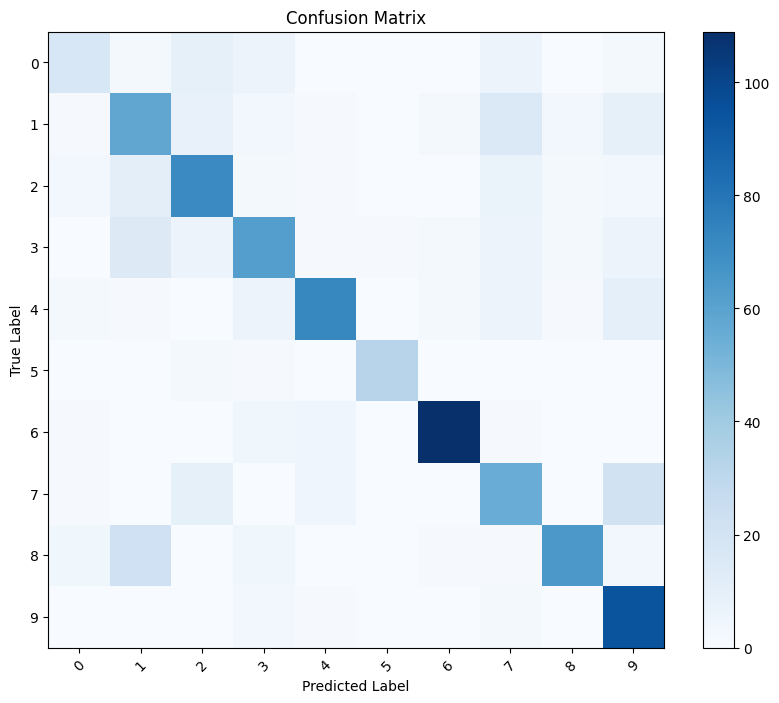

In [ ]:
# Display the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(mlp_avg_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

Convlutional Neural Network

In [ ]:
# Display the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cnn_avg_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')